## Global Mean Temperature From .nc file

In [5]:
!pip install netCDF4

In [6]:
import os
import numpy as np
from netCDF4 import Dataset
from datetime import datetime, timedelta

# Define the scenarios
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# Function to calculate days in a month considering leap years
def days_in_month(year, month):
    if month == 2:
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            return 29  # Leap year
        else:
            return 28  # Non-leap year
    else:
        return 31 - (month - 1) % 7 % 2

# Function to process data for a given model
def process_model(model, data_dir, output_dir):
    print(model)
    # Historical data processing
    years_historical = np.arange(1850, 2015)
    num_years_historical = len(years_historical)
    historical_data = np.zeros(num_years_historical)

    filename_historical = f'{data_dir}/tas_day_{model}_{scenarios[0]}.nc'
    nc_historical = Dataset(filename_historical, 'r')
    gg_historical = nc_historical.variables['tas'][:]
    date_historical = nc_historical.variables['time'][:]  # Assuming 'time' variable holds days since a reference date
    ref_date = datetime(1850, 1, 1)

    for i in range(num_years_historical):
        start_date = datetime(years_historical[i], 1, 1)
        end_date = datetime(years_historical[i], 12, 31)

        # Convert time values to datetime objects
        dates = [ref_date + timedelta(days=int(date)) for date in date_historical]

        # Create boolean mask z for current year's range
        z = np.array([start_date <= date <= end_date for date in dates])

        # Ensure z has the correct shape and matches gg's first dimension
        if z.shape[0] != gg_historical.shape[0]:
            if z.shape[0] == gg_historical.shape[0] - 1:
                z = np.append(z, False)  # Adjusting z to match gg's dimension
            else:
                print(f"Shape mismatch: z.shape[0]={z.shape[0]}, gg_historical.shape[0]={gg_historical.shape[0]}")
                continue  # Skip this iteration or handle the mismatch as needed

        # Index gg with z and calculate mean along the time dimension
        ggg = gg_historical[z, :, :]
        historical_data[i] = np.mean(ggg)

    # Initialize the result matrix
    num_years_future = 2100 - 2015 + 1
    result = np.zeros((num_years_historical + num_years_future, len(scenarios) + 1))  # Assuming 5 scenarios + years column
    result[:, 0] = np.concatenate((years_historical, np.arange(2015, 2101)))
    # print(result)
    # Fill the result matrix with historical data
    result[:num_years_historical, 1] = historical_data

    # Future data processing for each scenario
    for s in range(1, len(scenarios)):
        future_data = np.zeros(num_years_future)
        filename_future = f'{data_dir}/tas_day_{model}_{scenarios[s]}.nc'
        nc_future = Dataset(filename_future, 'r')
        gg_future = nc_future.variables['tas'][:]

        date_future = []
        for year in range(2015, 2101):
            for month in range(1, 13):
                max_day = days_in_month(year, month)
                for day in range(1, max_day + 1):
                    date_future.append(datetime(year, month, day))

        date_future = np.array(date_future)  # Convert to numpy array for indexing

        for i in range(num_years_future):
            start_date = datetime(2015 + i, 1, 1)
            end_date = datetime(2015 + i, 12, 31)

            # Create boolean mask z for current year's range
            z = np.array([start_date <= date <= end_date for date in date_future])

            # Ensure z has the correct shape and matches gg's first dimension
            if z.shape[0] != gg_future.shape[0]:
                z = z[:gg_future.shape[0]]  # Trim z if it's longer than gg_future

            ggg = gg_future[z, :, :]
            future_data[i] = np.mean(ggg)

        # Fill the result matrix with future scenario data
        result[num_years_historical:, s + 1] = future_data

    # Save the result matrix as a text file
    np.savetxt(f'{output_dir}/{model}_Global_mean_temp.txt', result, fmt=['%d'] + ['%.2f'] * (len(scenarios)), delimiter=' ')




In [7]:
import os
import numpy as np
from netCDF4 import Dataset
from datetime import datetime, timedelta
# Define directories
data_dir = '/DATA1/ankit_new_data/gmt_data'
output_dir = '/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature'

# List all files in the data directory
files = os.listdir(data_dir)

# Extract unique model names
unique_models = set()
for file in files:
    if file.endswith('.nc'):
        model = file.split('_')[2]
        unique_models.add(model)

# Process each unique model
for model in unique_models:
    process_model(model, data_dir, output_dir)

MIROC6
IPSL-CM6A-LR
MRI-ESM2-0
GFDL-ESM4


## Global_Mean_Temperature Plotting

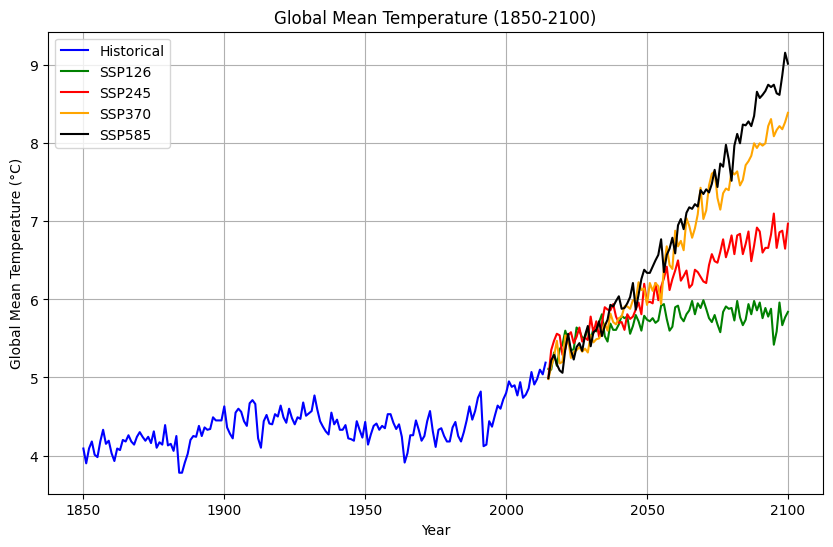

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path
file_path = "/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature/GFDL-ESM4_Global_mean_temp.txt"

# Read the data from the file
data = pd.read_csv(file_path, delim_whitespace=True, header=None)
data.columns = ['Year', 'Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']

# Convert temperatures from Kelvin to Celsius
data[['Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']] -= 273.15

# Split the data based on the year
historical = data[data['Year'] <= 2014][['Year', 'Historical']]
ssp126 = data[data['Year'] > 2014][['Year', 'SSP126']]
ssp245 = data[data['Year'] > 2014][['Year', 'SSP245']]
ssp370 = data[data['Year'] > 2014][['Year', 'SSP370']]
ssp585 = data[data['Year'] > 2014][['Year', 'SSP585']]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(historical['Year'], historical['Historical'], label='Historical', color='blue')
plt.plot(ssp126['Year'], ssp126['SSP126'], label='SSP126', color='green')
plt.plot(ssp245['Year'], ssp245['SSP245'], label='SSP245', color='red')
plt.plot(ssp370['Year'], ssp370['SSP370'], label='SSP370', color='orange')
plt.plot(ssp585['Year'], ssp585['SSP585'], label='SSP585', color='black')
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature (1850-2100)')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("Global_Mean_Temperature_1850_2100.png")

# Show the plot
plt.show()


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# Define the data and output directories
data_dir = "/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature/"
output_dir = "/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature/Global Mean Temperature Plots"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all files in the directory (filtering out directories)
file_list = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

for file_name in file_list:
    # Extract the model name 
    model_name = file_name.split('_')[0]
    
    # Construct full file path
    file_path = os.path.join(data_dir, file_name)

    # Read the data and set column names (assuming consistent format)
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    data.columns = ['Year', 'Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']

    # Convert temperatures from Kelvin to Celsius
    data[['Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']] -= 273.15

    # Split the data based on the year
    historical = data[data['Year'] <= 2014][['Year', 'Historical']]
    ssp126 = data[data['Year'] > 2014][['Year', 'SSP126']]
    ssp245 = data[data['Year'] > 2014][['Year', 'SSP245']]
    ssp370 = data[data['Year'] > 2014][['Year', 'SSP370']]
    ssp585 = data[data['Year'] > 2014][['Year', 'SSP585']]

    # Create a new figure for each model
    plt.figure(figsize=(10, 6))

    # Plot the data for the current model
    plt.plot(historical['Year'], historical['Historical'], label=f'{model_name} Historical', color='blue')
    plt.plot(ssp126['Year'], ssp126['SSP126'], label=f'{model_name} SSP126', color='green')
    plt.plot(ssp245['Year'], ssp245['SSP245'], label=f'{model_name} SSP245', color='red')
    plt.plot(ssp370['Year'], ssp370['SSP370'], label=f'{model_name} SSP370', color='orange')
    plt.plot(ssp585['Year'], ssp585['SSP585'], label=f'{model_name} SSP585', color='black')
    
    print(f"Plotted data from {model_name}")  # Optional: Print feedback

    # Add labels and title (including model name)
    plt.xlabel('Year')
    plt.ylabel('Global Mean Temperature (°C)')
    plt.title(f'Global Mean Temperature {model_name} (1850-2100)')  # Include model name
    plt.legend()
    plt.grid(True)

    # Save the plot in the output directory
    output_file_path = os.path.join(output_dir, f"Global_Mean_Temperature_{model_name}.png")
    plt.savefig(output_file_path)
    plt.close()  # Close the figure to avoid overlapping plots


Plotted data from MRI-ESM2-0
Plotted data from IPSL-CM6A-LR
Plotted data from GFDL-ESM4
Plotted data from MIROC6


## Finding ssp(126/245/370/585) Senerios in each model

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data and output directories
data_dir = "/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature/"
output_dir = "/DATA1/ankit_new_data/gmt_data/Global_Mean_Temperature/Global_Mean_Temperature_Plots"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all files in the directory (filtering out directories)
file_list = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

for file_name in file_list:
    # Extract the model name 
    model_name = file_name.split('_')[0]
    
    # Construct full file path
    file_path = os.path.join(data_dir, file_name)

    # Read the data and set column names
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    data.columns = ['Year', 'Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']

    # Convert temperatures from Kelvin to Celsius
    data[['Historical', 'SSP126', 'SSP245', 'SSP370', 'SSP585']] -= 273.15
    #print(data)
    # Calculate pre-industrial mean (1861-1900)
    pre_industrial_mean = data[(data['Year'] >= 1861) & (data['Year'] <= 1900)]['Historical'].mean()
    #print(pre_industrial_mean)

    # Filter data to the relevant time periods (1950-2100)
    scenarios = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
    data_filtered = data[data['Year'] >= 2015][['Year'] + scenarios]
   
    # Calculate differences from pre-industrial mean
    for scenario in scenarios:
        data_filtered[scenario + '_diff'] = data_filtered[scenario] - pre_industrial_mean
       # print(data_filtered[scenario + '_diff'])

    # Create a new figure for each model
    plt.figure(figsize=(10, 6))

    # Plot the temperature differences for each scenario
    for scenario in scenarios:
        plt.plot(data_filtered['Year'], data_filtered[scenario + '_diff'], label=f'{model_name} {scenario}')

    # Add labels and title (including model name)
    plt.xlabel('Year')
    plt.ylabel('Temperature Difference from Pre-industrial (°C)')
    plt.title(f'Global Mean Temperature Difference {model_name} (2015-2100)')
    plt.legend()
    plt.grid(True)
    # plt.show()
    print(model_name)
    # Save the plot in the output directory
    output_file_path = os.path.join(output_dir, f"Global_Mean_Temperature_Difference_{model_name}.png")
    plt.savefig(output_file_path)
    plt.close() # Close the figure to avoid overlapping plots


MRI-ESM2-0
IPSL-CM6A-LR
GFDL-ESM4
MIROC6
